## Loading of Stringer spontaneous data

includes some visualizations

In [1]:
from collections import defaultdict

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
import scipy.stats

C:\Users\Leo\miniconda3\envs\nma-compneuro\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Leo\miniconda3\envs\nma-compneuro\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Leo\miniconda3\envs\nma-compneuro\lib\site-packages\umap\distances.

In [3]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [4]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [5]:
# @title Data loading

dat = np.load('../../data/stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [6]:
dat["beh_svd_time"][0].shape

(1000,)


dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [7]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(11983, 7018)
11983


In [8]:
for k, v in dat.items():
  print("Key: {}".format(k))
  print(v.shape)
  # try:
  #   print(v[:5,:5,:5])
  # except:
  #   print(v[:5,:5])


Key: sresp
(11983, 7018)
Key: run
(7018, 1)
Key: beh_svd_time
(7018, 1000)
Key: beh_svd_mask
(240, 320, 1000)
Key: stat
(11983, 1)
Key: pupilArea
(7018, 1)
Key: pupilCOM
(7018, 2)
Key: xyz
(3, 11983)


In [9]:
dat["sresp"][0]

array([ 2.9820833,  8.409119 , 12.720393 , ...,  0.       , 11.900859 ,
        7.5612717], dtype=float32)

In [79]:
dat['xyz'] = dat['xyz'].astype(int)

# Neural EDA

## Deconvlving the neural activity

In [10]:
# compute deconvolution
from suite2p.extraction import dcnv
import numpy as np

In [11]:
tau = 2.0 # timescale of indicator
# fs = 30.0 # sampling rate in Hz
fs = 1 # sampling rate in Hz
neucoeff = 0.7 # neuropil coefficient
# for computing and subtracting baseline
baseline = 'maximin' # take the running max of the running min after smoothing with gaussian
sig_baseline = 10.0 # in bins, standard deviation of gaussian with which to smooth
win_baseline = 60.0 # in seconds, window in which to compute max/min filters

ops = {'tau': tau, 'fs': fs, 'neucoeff': neucoeff,
       'baseline': baseline, 'sig_baseline': sig_baseline, 'win_baseline': win_baseline,
      'batchsize': 500}


In [12]:
# load traces and subtract neuropil
Fc = dat["sresp"]

In [13]:
# baseline operation
Fc = dcnv.preprocess(
     F=Fc,
     baseline=ops['baseline'],
     win_baseline=ops['win_baseline'],
     sig_baseline=ops['sig_baseline'],
     fs=ops['fs'],
     # prctile_baseline=ops['prctile_baseline']
 )


In [14]:

# get spikes
spks = dcnv.oasis(F=Fc, batch_size=ops["batchsize"], tau=ops['tau'], fs=ops['fs'])

In [15]:
spks

array([[0.0000000e+00, 4.1391048e+00, 0.0000000e+00, ..., 0.0000000e+00,
        3.0411704e+00, 0.0000000e+00],
       [0.0000000e+00, 1.9426782e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.1780296e+01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.2622709e-01,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        6.0082603e+00, 8.4497406e+01],
       [0.0000000e+00, 2.3894440e+01, 9.2651260e+01, ..., 0.0000000e+00,
        0.0000000e+00, 6.5612289e+01],
       [0.0000000e+00, 4.6515699e-02, 1.2800403e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [16]:
z_scored_trace = zscore(dat["sresp"][0])

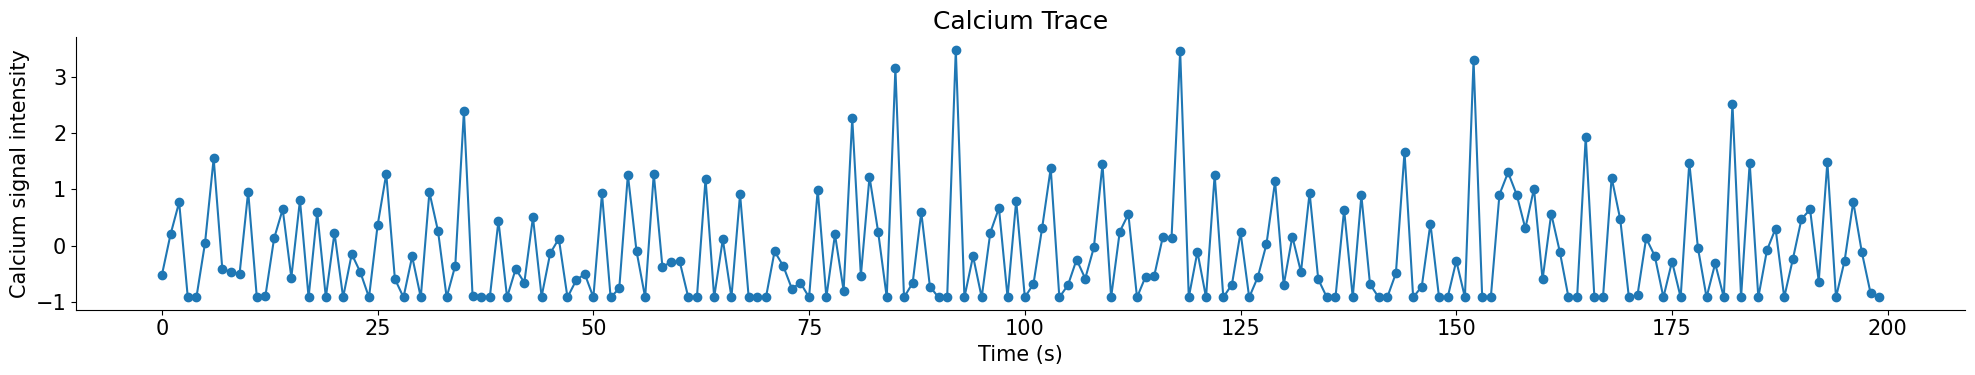

In [17]:

plt.plot(z_scored_trace[:200], marker='o')
plt.title('Calcium Trace')
plt.xlabel('Time (s)')
plt.ylabel('Calcium signal intensity')
plt.show()

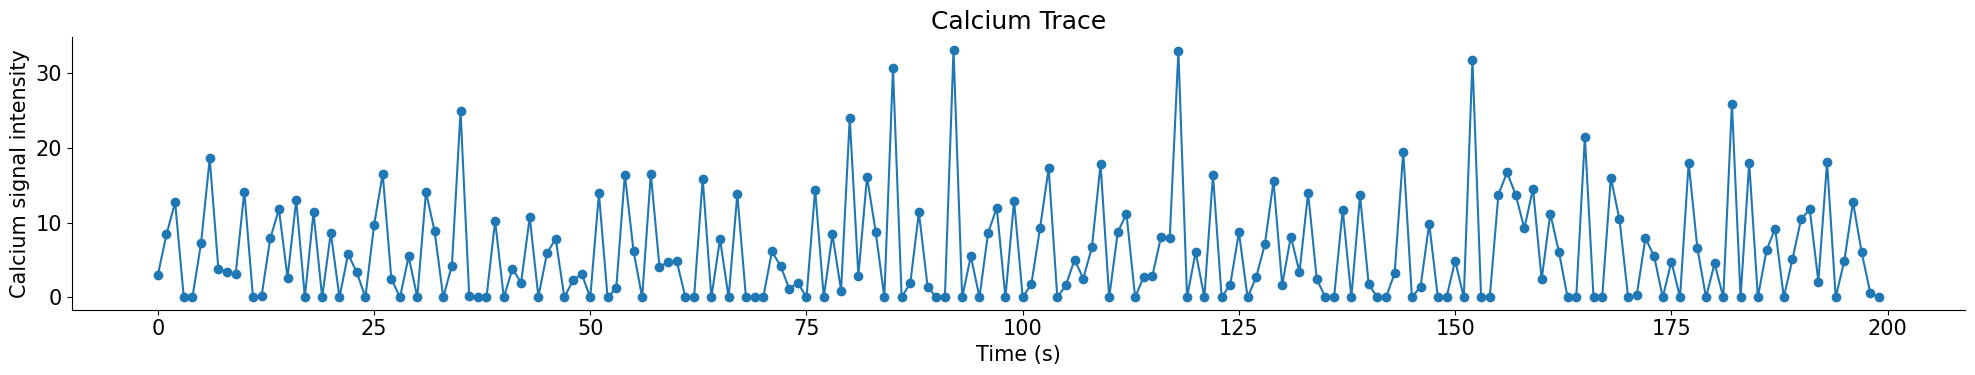

In [18]:
plt.plot(dat["sresp"][0][:200], marker='o')
plt.title('Calcium Trace')
plt.xlabel('Time (s)')
plt.ylabel('Calcium signal intensity')
plt.show()

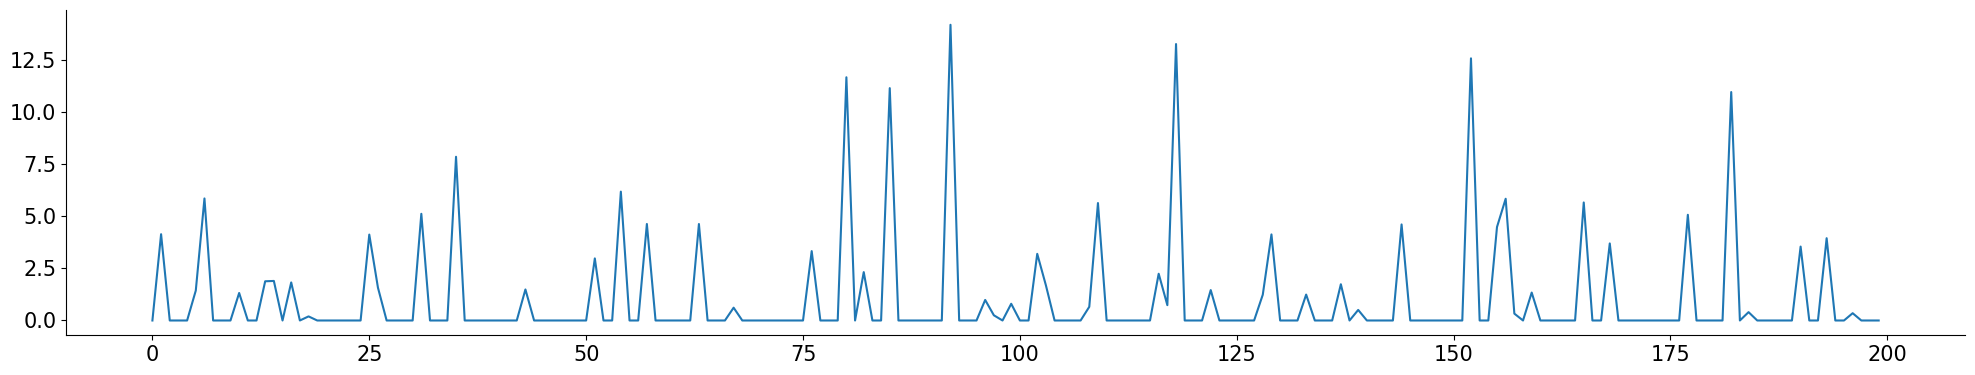

In [19]:
plt.plot(spks[0][:200])

## Spatial Coordinates

- Looking at the spatial coordinates

In [20]:
dat["xyz"].shape

(3, 11983)

### Spatial plotting code from the example

In [80]:
# Separating each coordinate into separate axis
x, y, z = dat['xyz']

(array([ 682.,  787., 1036., 1213., 1331., 1264., 1443., 1552., 1410.,
        1265.]),
 array([   4. ,  104.6,  205.2,  305.8,  406.4,  507. ,  607.6,  708.2,
         808.8,  909.4, 1010. ]),
 <BarContainer object of 10 artists>)

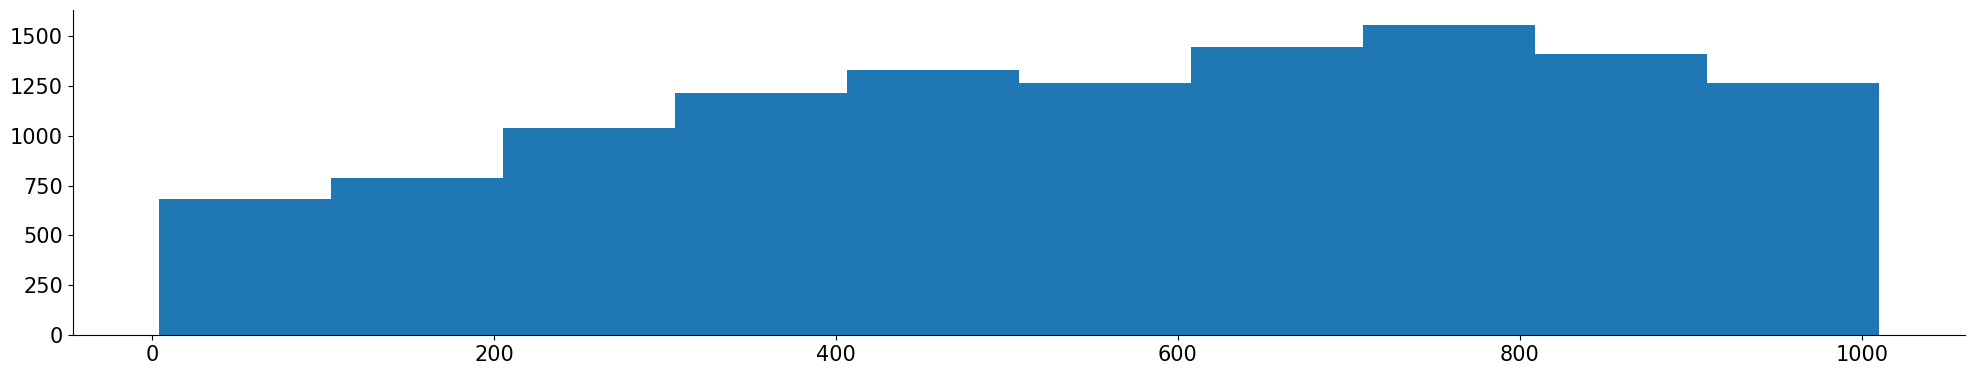

In [83]:
plt.hist(x)

(array([1380., 1574., 1481., 1411., 1216., 1067., 1104., 1121.,  818.,
         811.]),
 array([   4. ,  104.8,  205.6,  306.4,  407.2,  508. ,  608.8,  709.6,
         810.4,  911.2, 1012. ]),
 <BarContainer object of 10 artists>)

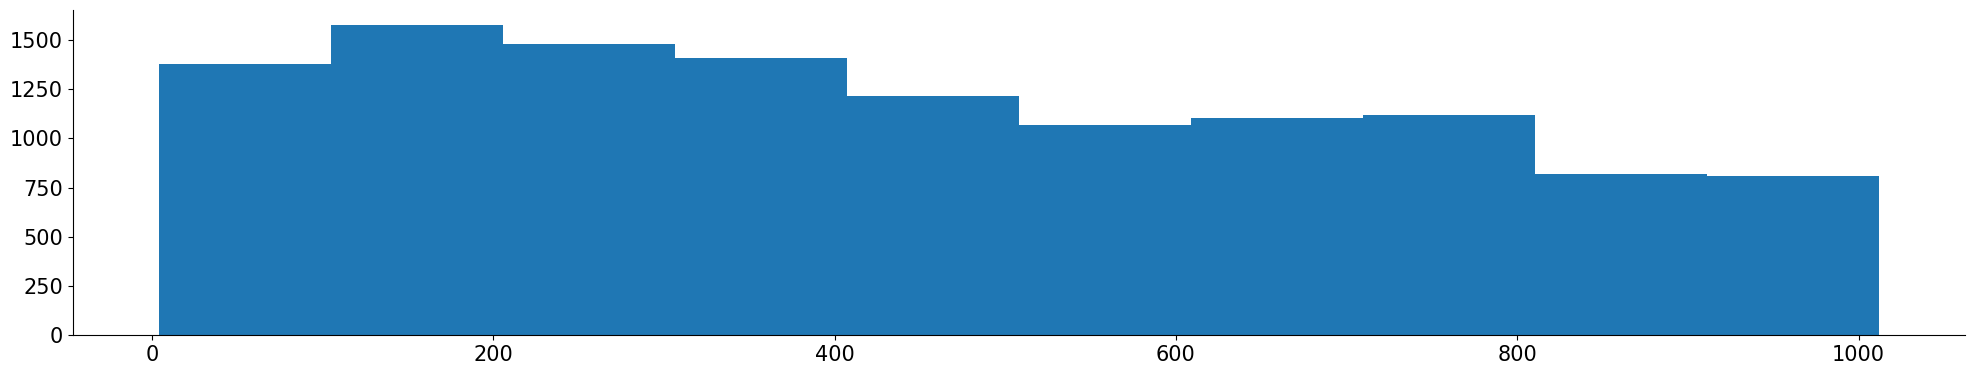

In [84]:
plt.hist(y)

In [85]:
x.shape

(11983,)

(array([ 682.,  787., 1036., 1213., 1331., 1264., 1443., 1552., 1410.,
        1265.]),
 array([   4. ,  104.6,  205.2,  305.8,  406.4,  507. ,  607.6,  708.2,
         808.8,  909.4, 1010. ]),
 <BarContainer object of 10 artists>)

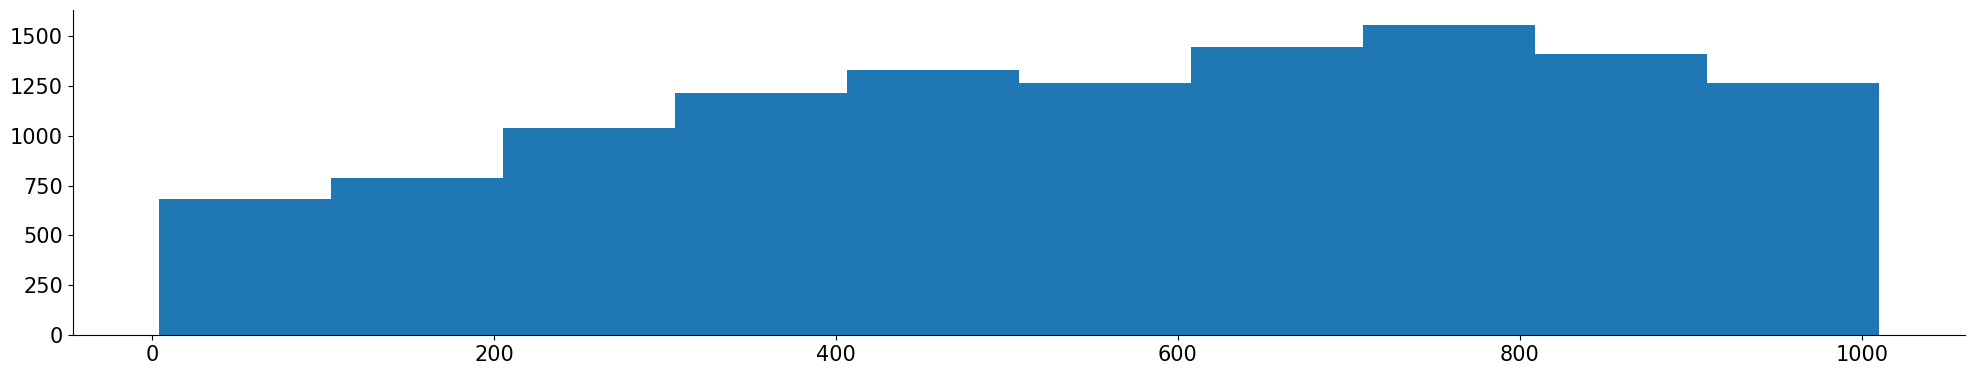

In [86]:
plt.hist(x)

In [87]:
all_depths = np.unique(z)

In [88]:
all_depths

array([-390, -360, -330, -300, -270, -240, -210, -180, -150])

In [89]:
depth_to_neural = defaultdict(dict)

In [90]:
for depth in all_depths:
    depth_to_neural[depth]["neural_index"] = np.where(z == depth)[0]

In [91]:
depth_to_neural[-150]["neural_index"].shape

(1131,)

In [92]:
depth_to_neural[-390]["neural_index"].shape

(1386,)

# Spatial Activity Maps

- Example code from ChatGPT

In [93]:
import numpy as np

# Assuming we have the following 1D array
values = np.array([10, 20, 30, 40, 50])

# And these are the (x, y) coordinates for each index
coords = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4]])

# Create an empty 2D array with the size being the maximum coordinates + 1
size = np.max(coords, axis=0) + 1
two_d_array = np.zeros(size)

# Use the coordinates to index into the 2D array and assign the values all at once
two_d_array[coords[:, 0], coords[:, 1]] = values

print(two_d_array)

[[10.  0.  0.  0.  0.]
 [ 0. 20.  0.  0.  0.]
 [ 0.  0. 30.  0.  0.]
 [ 0.  0.  0. 40.  0.]
 [ 0.  0.  0.  0. 50.]]


In [94]:
import numpy as np

# Assuming we have the following 2D array, where each row corresponds to a different time point
values = np.array([[10, 20, 30, 40, 50],
                   [60, 70, 80, 90, 100]])

# These are the (x, y) coordinates for each index
coords = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4]])

# Get the number of time points
num_time_points = values.shape[0]

# Create an empty 3D array with size being (num_time_points, max_x_coord+1, max_y_coord+1)
size = np.concatenate(([num_time_points], np.max(coords, axis=0) + 1))
three_d_array = np.zeros(size)

# Use the coordinates to index into the 3D array and assign the values all at once
three_d_array[:, coords[:, 0], coords[:, 1]] = values

print(three_d_array)

[[[ 10.   0.   0.   0.   0.]
  [  0.  20.   0.   0.   0.]
  [  0.   0.  30.   0.   0.]
  [  0.   0.   0.  40.   0.]
  [  0.   0.   0.   0.  50.]]

 [[ 60.   0.   0.   0.   0.]
  [  0.  70.   0.   0.   0.]
  [  0.   0.  80.   0.   0.]
  [  0.   0.   0.  90.   0.]
  [  0.   0.   0.   0. 100.]]]


- Creating Activity maps

In [137]:
dat["xyz"][0].max()

1010

In [138]:
dat["xyz"][0].min()

4

In [139]:
dat["xyz"][1].max()

1012

In [147]:
for depth in all_depths:
    current_layer_index = depth_to_neural[depth]["neural_index"]

    # Assuming we have the following 2D array, where each row corresponds to a different time point
    firing_rate = spks[current_layer_index].T
    # Get the number of time points
    num_time_points = firing_rate.shape[0]
    
    # These are the (x, y) coordinates for each index
    coordinates = dat["xyz"][:2, current_layer_index].T

    # Define the size of the grid
    grid_size = [100, 100]  # Adjust this depending on your data
    
    # Normalize coordinates to grid size
    normalized_coordinates = (coordinates - coordinates.min(axis=0)) / (coordinates.max(axis=0) - coordinates.min(axis=0))
    normalized_coordinates = (normalized_coordinates * np.array(grid_size)).astype(int)

    # Create an empty 3D array with size being (num_time_points, max_x_coord+1, max_y_coord+1)
    size = np.concatenate(([num_time_points], np.max(normalized_coordinates, axis=0) + 1))
    three_d_array = np.zeros(size)
    
    # Use the coordinates to index into the 3D array and assign the values all at once
    three_d_array[:, normalized_coordinates[:, 0], normalized_coordinates[:, 1]] = firing_rate

    depth_to_neural[depth]["activty_map"] = three_d_array

## UMAP dimensionality reduction

In [148]:
three_d_array = depth_to_neural[depth]["activty_map"]

In [149]:
data = three_d_array.reshape(three_d_array.shape[0], -1)


In [150]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

In [157]:
embedding.shape

(7018, 2)

In [158]:
import copy

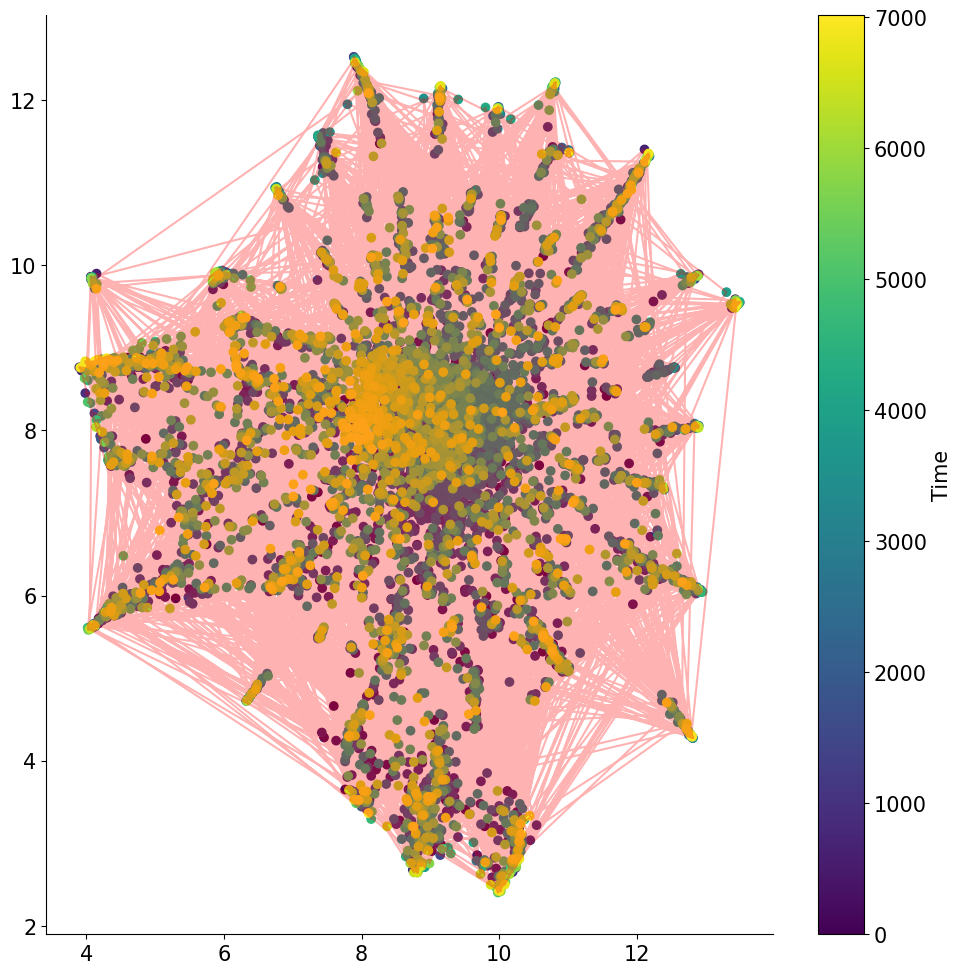

In [155]:
plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=range(embedding.shape[0]), cmap='viridis')
plt.plot(embedding[:, 0], embedding[:, 1], color='r', alpha=0.3) # This line connects the points
plt.colorbar(label='Time')
plt.show()

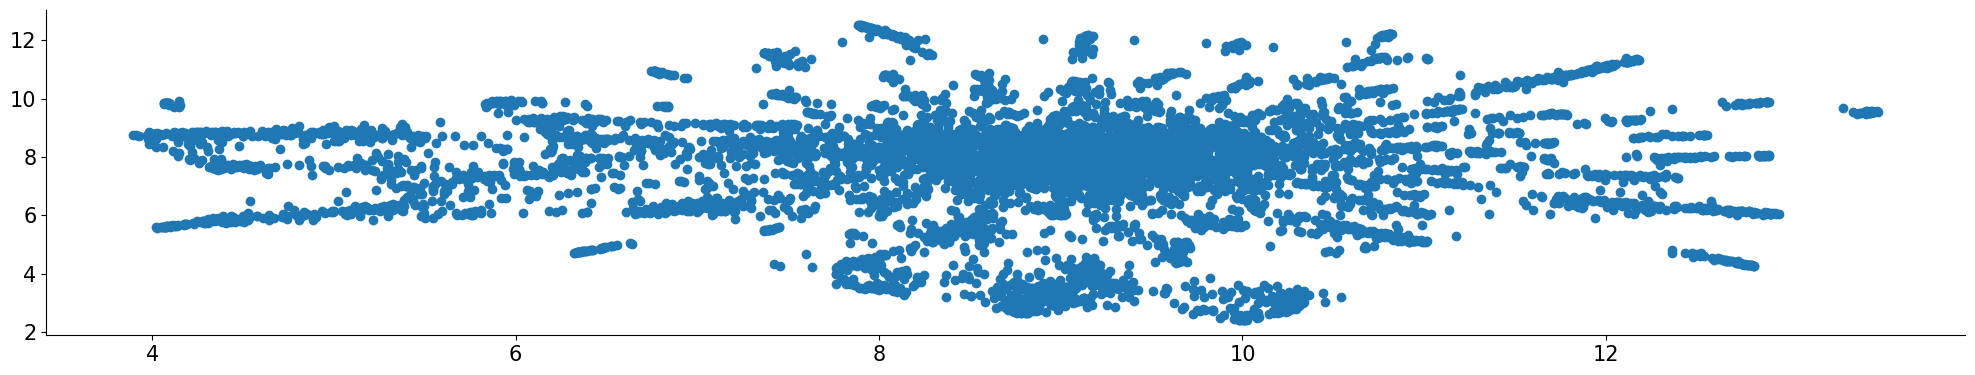

In [151]:
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.show()

### Plotting based on layers

C:\Users\Leo\AppData\Local\Temp\ipykernel_64312\4245094710.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


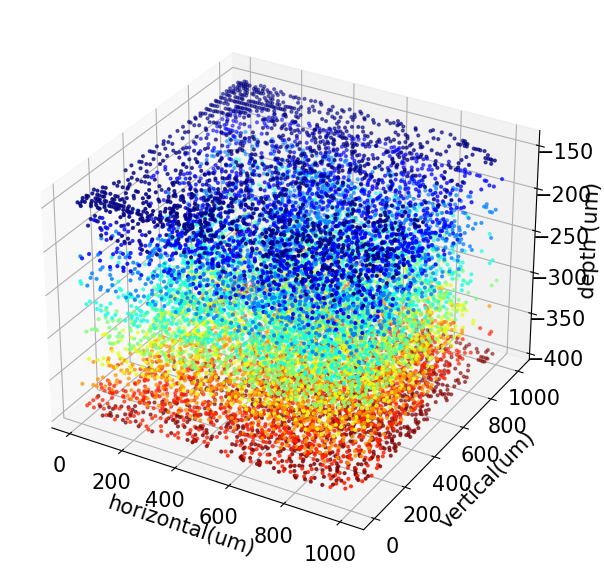

In [30]:
zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

In [31]:
spks[:,10].shape

(11983,)

(array([1.1913e+04, 4.3000e+01, 1.2000e+01, 8.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([   0.        ,  125.51595306,  251.03190613,  376.54785156,
         502.06381226,  627.57977295,  753.09570312,  878.61169434,
        1004.12762451, 1129.64355469, 1255.1595459 ]),
 <BarContainer object of 10 artists>)

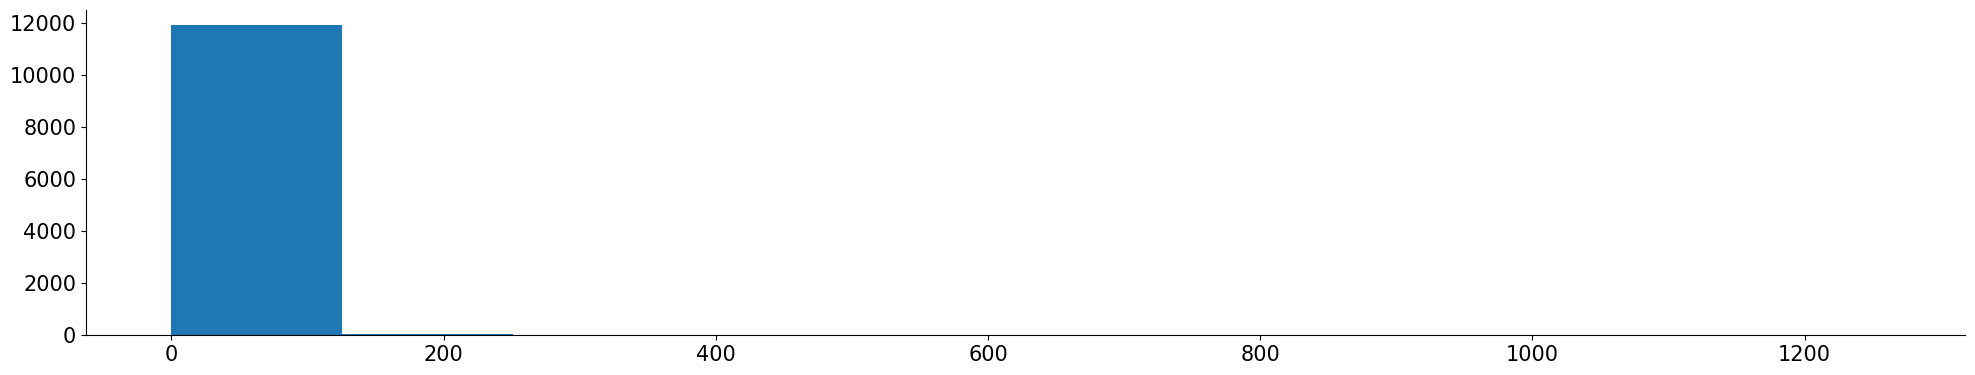

In [32]:
plt.hist(spks[:,10])

In [33]:
from matplotlib.cm import ScalarMappable


C:\Users\Leo\AppData\Local\Temp\ipykernel_64312\4079018232.py:5: RuntimeWarning: divide by zero encountered in log
  sc = ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=np.log(spks[:,num]), cmap='hot')


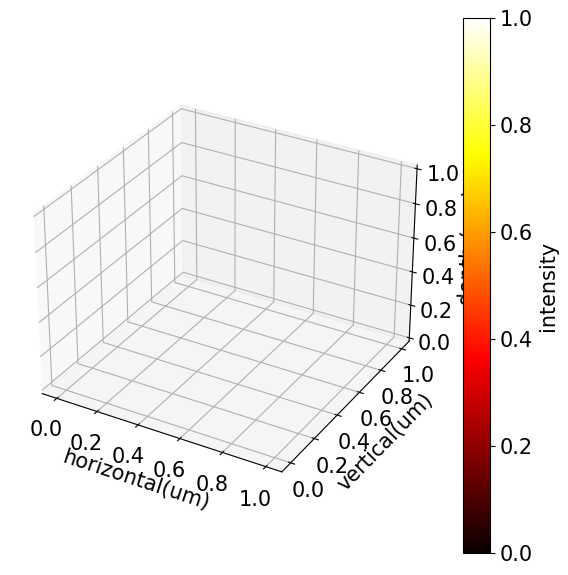

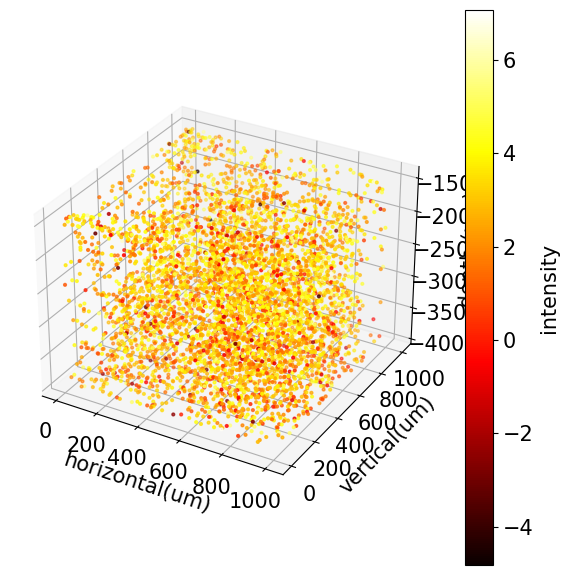

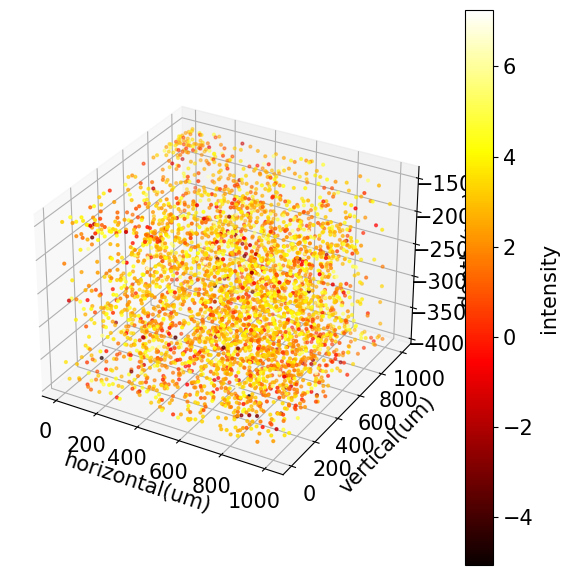

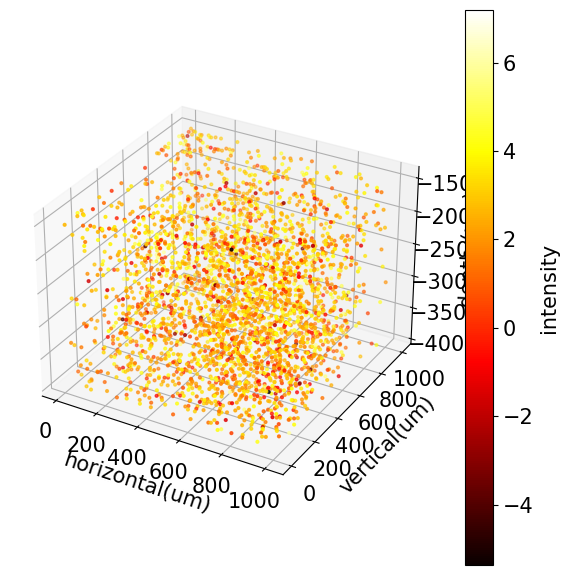

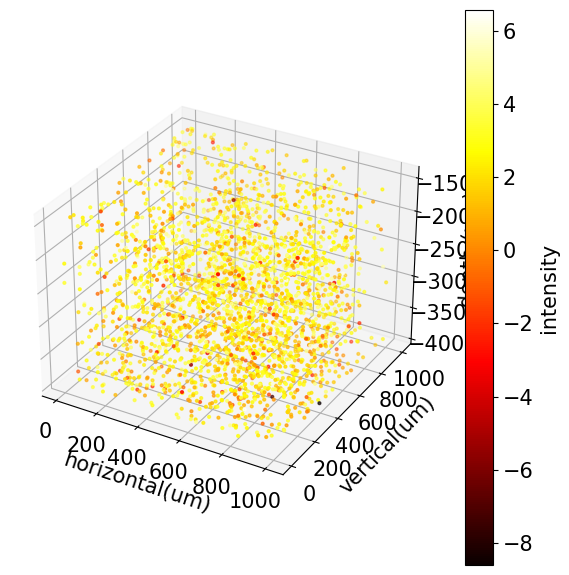

In [46]:
# for num in range(len(spks[:])):
for num in range(5):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=np.log(spks[:,num]), cmap='hot')
    ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
    
    # add a colorbar
    plt.colorbar(sc, label='intensity')
    plt.tight_layout()
    plt.show()

(array([1386., 1440., 1418., 1471.,    0., 1415., 1321., 1218., 1183.,
        1131.]),
 array([-390., -366., -342., -318., -294., -270., -246., -222., -198.,
        -174., -150.]),
 <BarContainer object of 10 artists>)

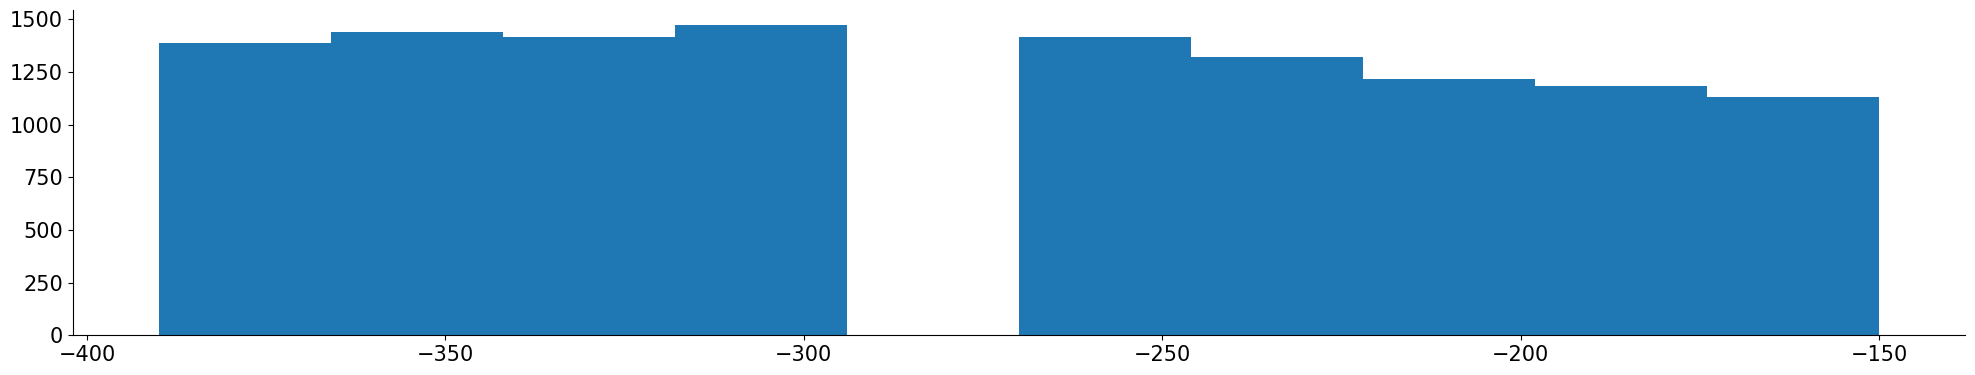

In [35]:
plt.hist(dat["xyz"][2])

## Spatial Dimensionality Reduction

In [36]:
from sklearn.manifold import SpectralEmbedding

In [37]:
dat["xyz"].shape

(3, 11983)

In [38]:
dat["xyz"][0]

array([174., 220.,  18., ..., 806., 944., 938.])

In [39]:
dat["xyz"]

array([[ 174.,  220.,   18., ...,  806.,  944.,  938.],
       [   6.,    4.,   16., ...,  510.,  638.,  978.],
       [-150., -150., -150., ..., -390., -390., -390.]])

In [40]:
dat["xyz"][2]

array([-150., -150., -150., ..., -390., -390., -390.])

In [41]:
spks.shape

(11983, 7018)

## Pupil Area Analysis

In [176]:
pupil_area = dat['pupilArea'][:,0]

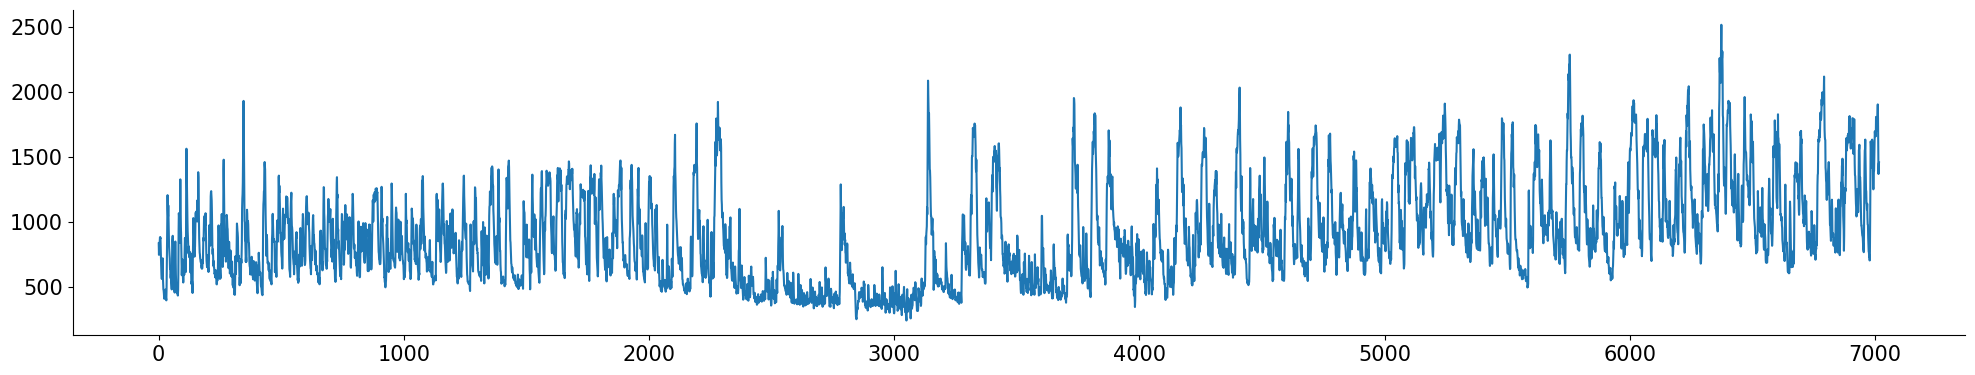

In [177]:
plt.plot(pupil_area)

(array([ 704., 1669., 1828., 1178.,  724.,  501.,  331.,   61.,   19.,
           3.]),
 array([ 238.46559326,  466.66464208,  694.86369091,  923.06273974,
        1151.26178857, 1379.4608374 , 1607.65988623, 1835.85893506,
        2064.05798389, 2292.25703272, 2520.45608155]),
 <BarContainer object of 10 artists>)

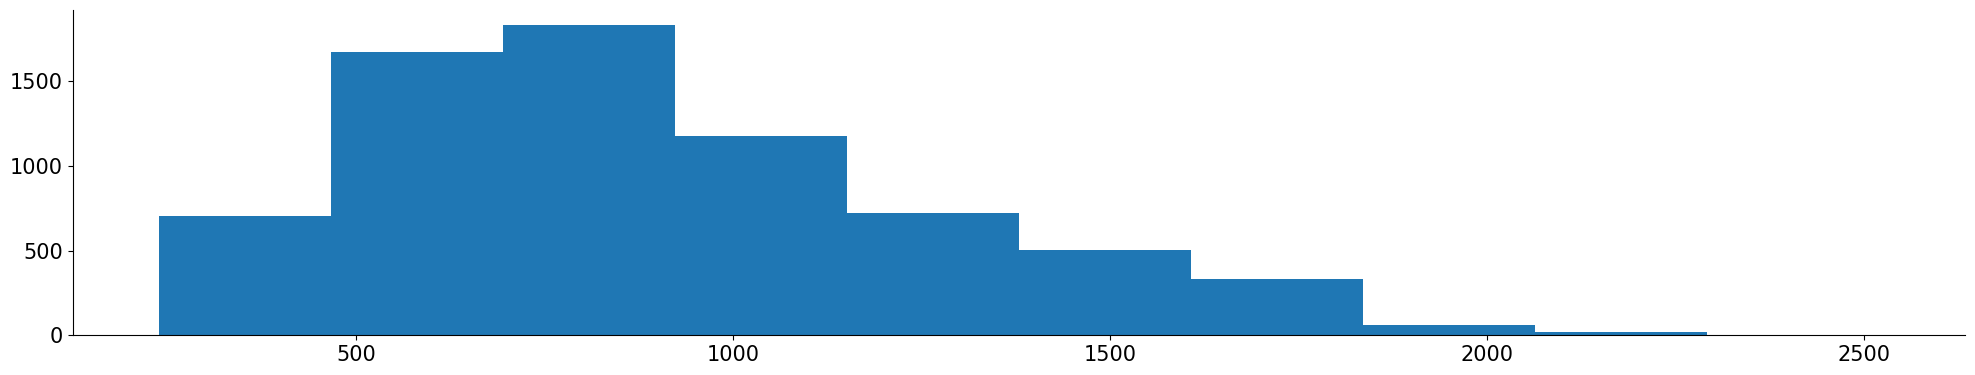

In [178]:
plt.hist(pupil_area)

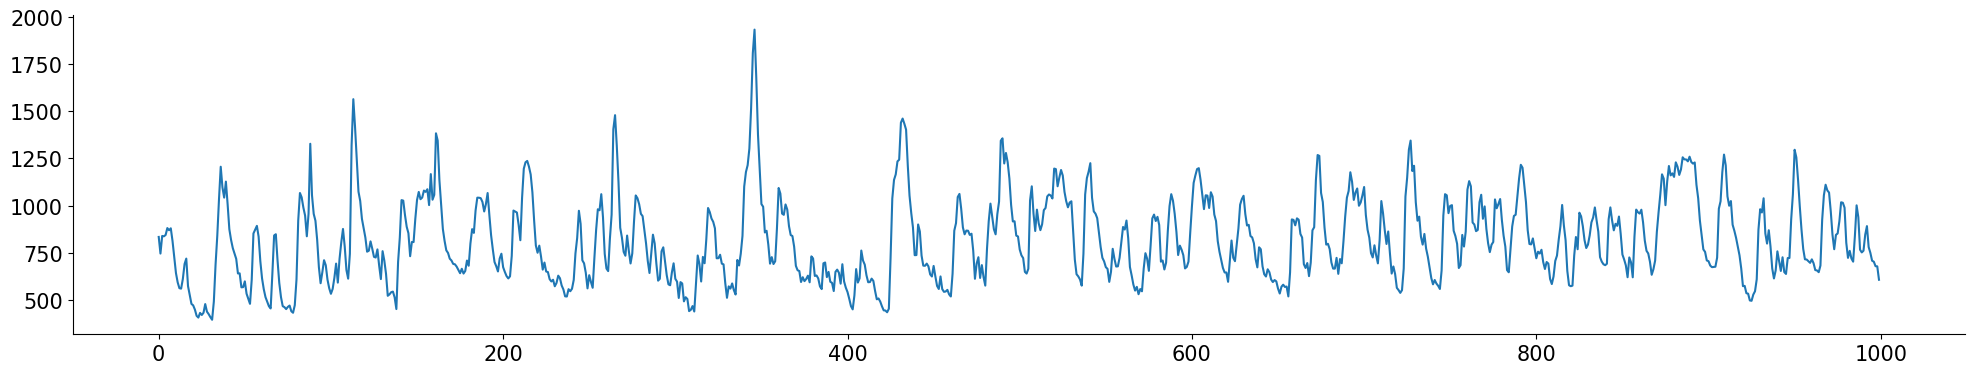

In [179]:
plt.plot(pupil_area[:1000])

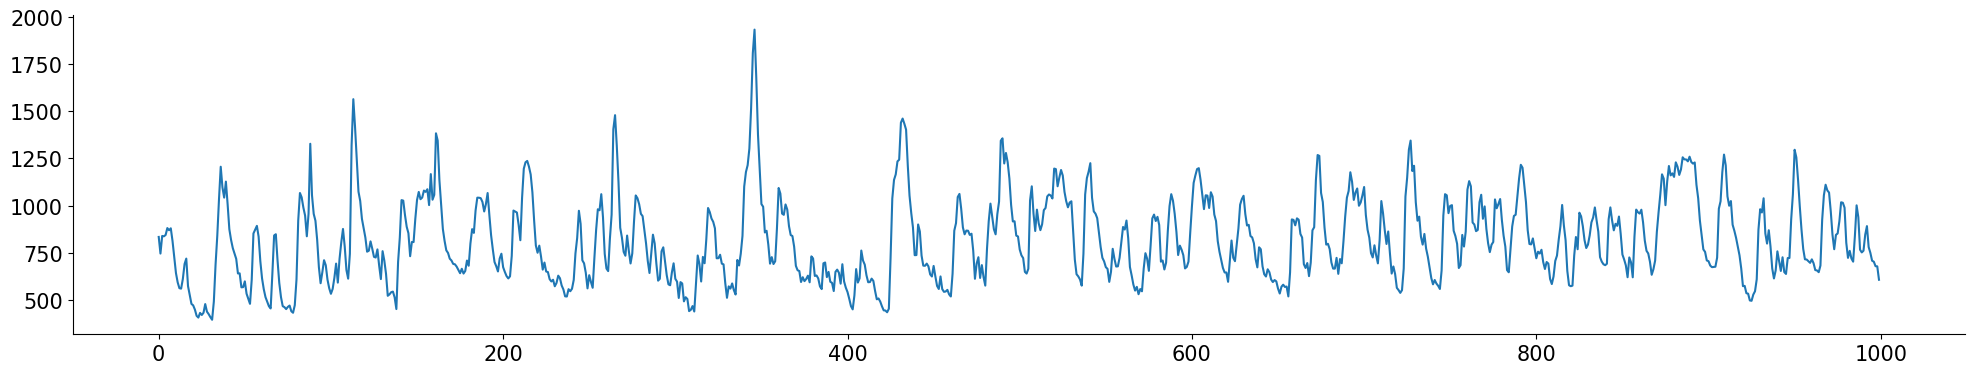

In [180]:
plt.plot(pupil_area[:1000])

### Getting the times when pupil area changes

In [181]:
pupil_z_scores = scipy.stats.zscore(pupil_area)

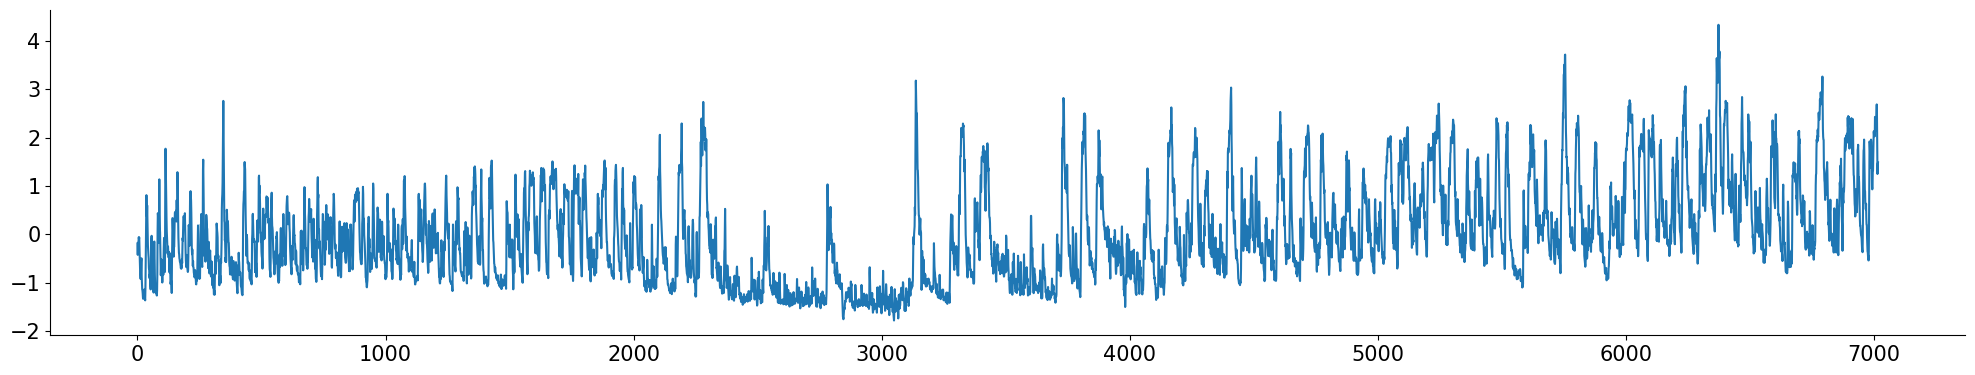

In [182]:
plt.plot(pupil_z_scores)

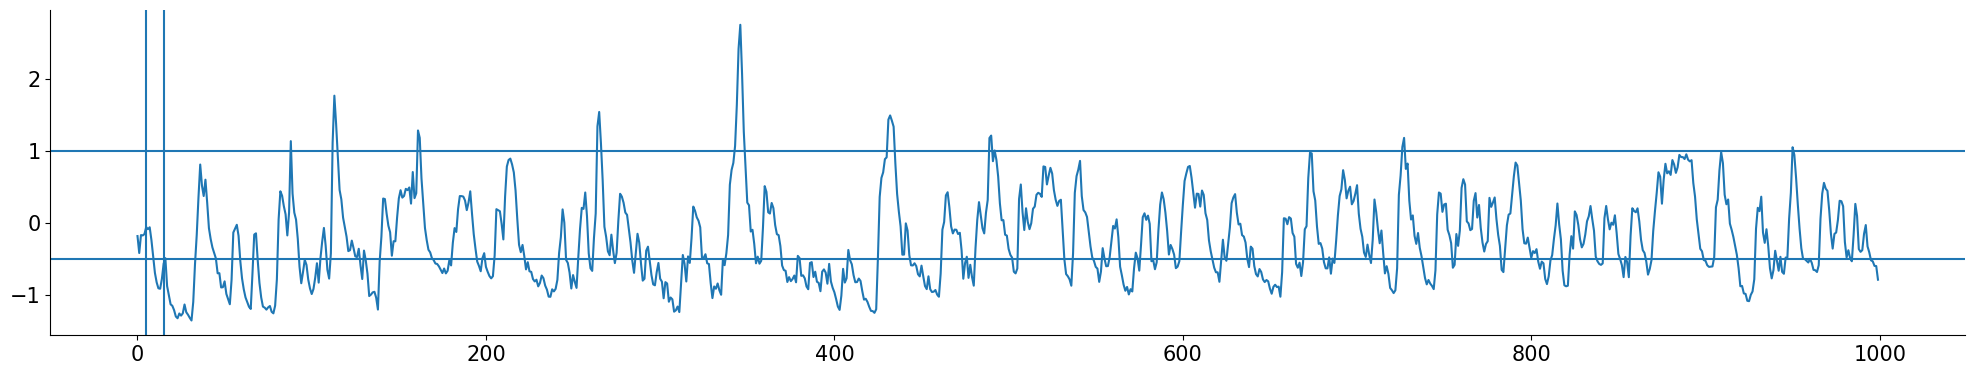

In [186]:
plt.plot(pupil_z_scores[:1000])
plt.axhline(-0.5)
plt.axhline(1)
plt.axvline(5)
plt.axvline(15)

In [199]:
small_pupil_indexes = np.where(pupil_z_scores < -1)[0]
big_pupil_indexes = np.where(pupil_z_scores > 1)[0]

In [201]:
small_pupil_indexes.shape

(1074,)

In [202]:
big_pupil_indexes.shape

(1220,)

In [203]:
def first_in_consecutive_sequence(lst):
    result = [lst[0]]  # first number is always included
    for i in range(1, len(lst)):
        if lst[i] - lst[i-1] != 1:
            result.append(lst[i])
    return result

In [205]:
small_pupil_indexes = first_in_consecutive_sequence(small_pupil_indexes)

In [206]:
big_pupil_indexes = first_in_consecutive_sequence(big_pupil_indexes)

In [211]:
index_threshold = 10

In [214]:
pairs = [(a, b) for a in small_pupil_indexes for b in big_pupil_indexes if abs(b - a) <= index_threshold]
print(pairs)

[(335, 343), (1410, 1419), (1515, 1523), (2091, 2100), (3861, 3868), (4444, 4452), (4447, 4452)]


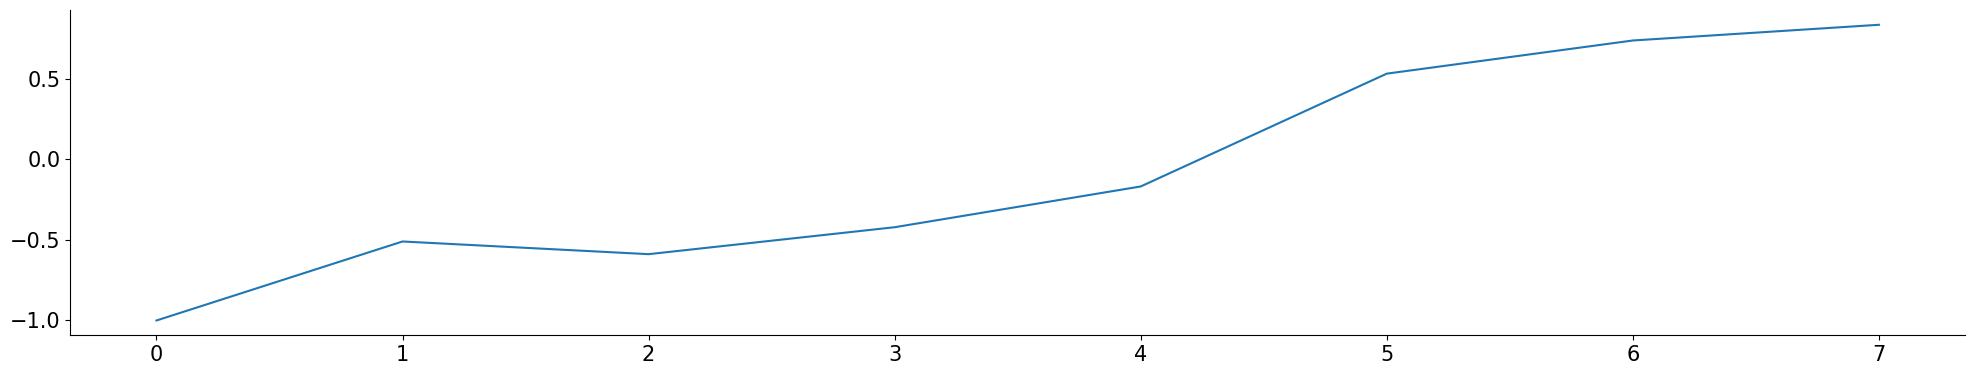

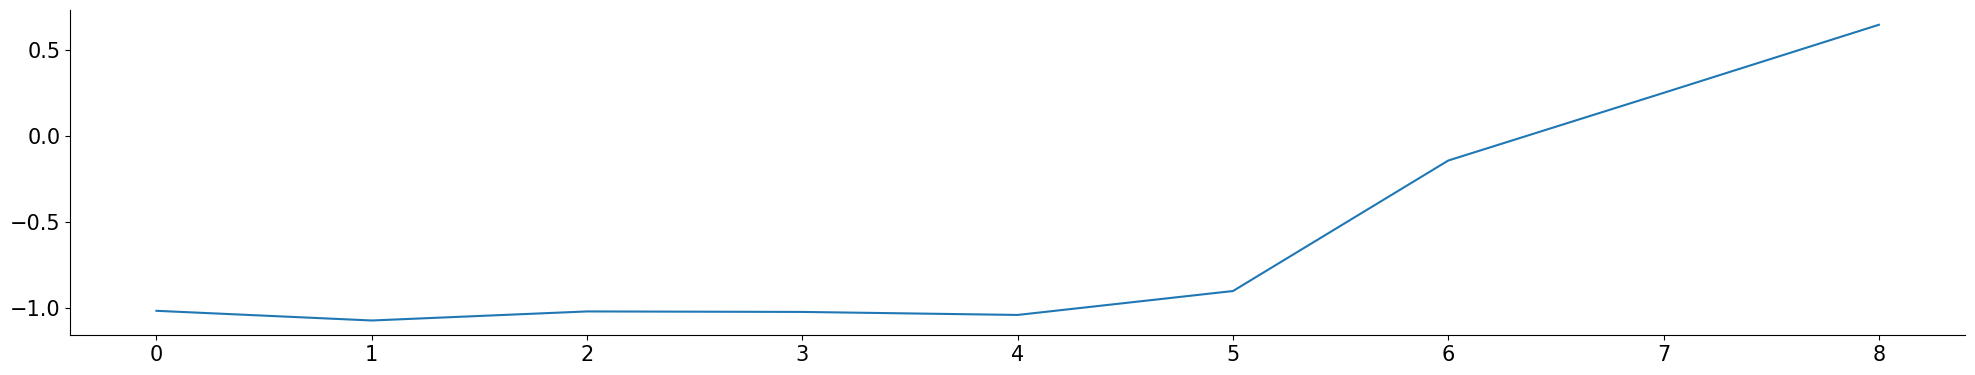

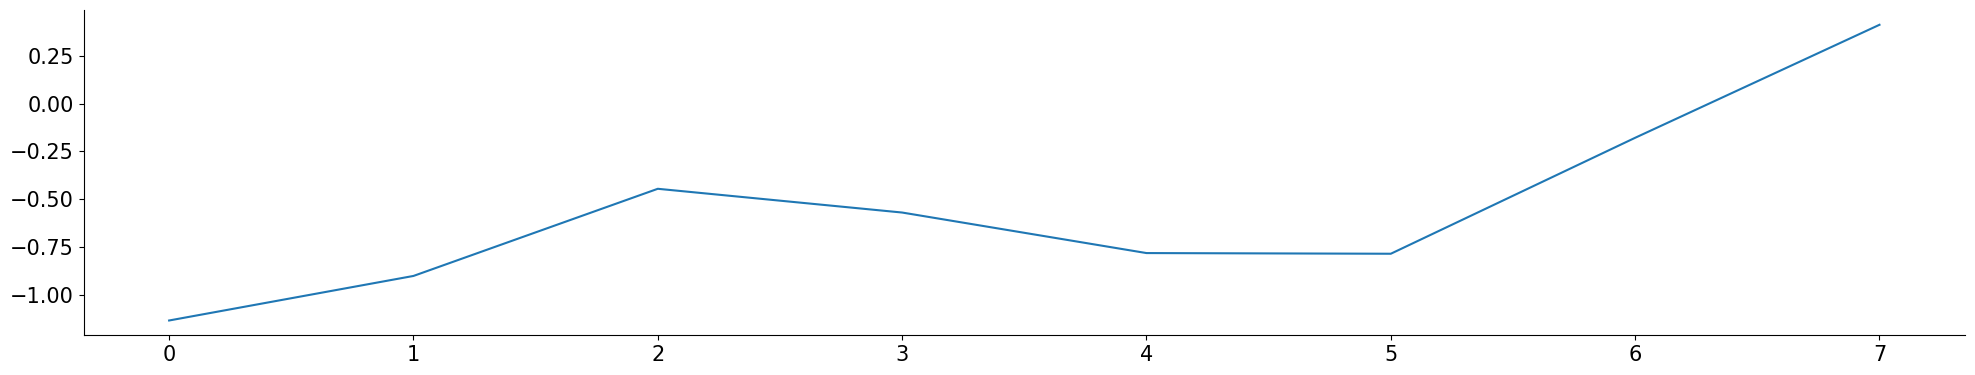

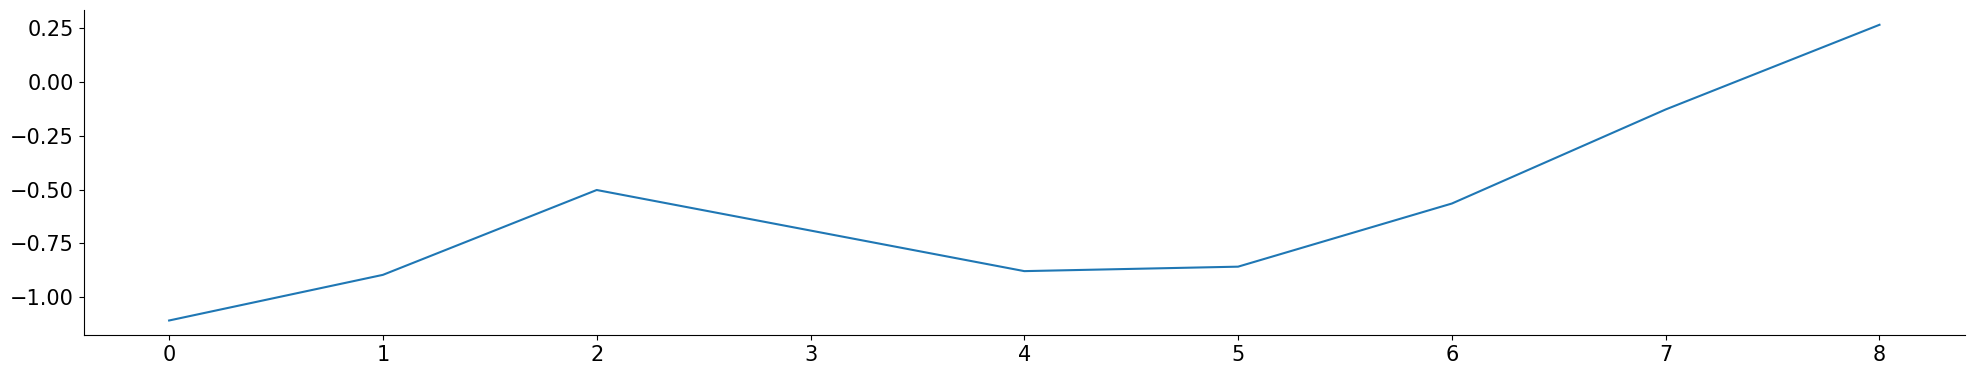

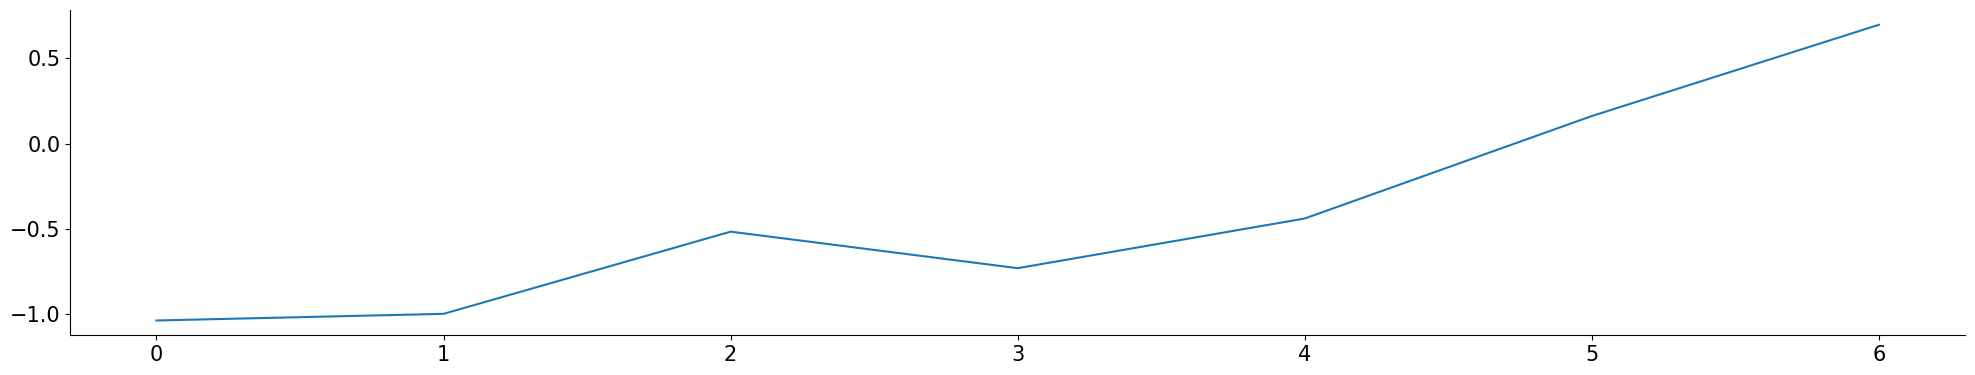

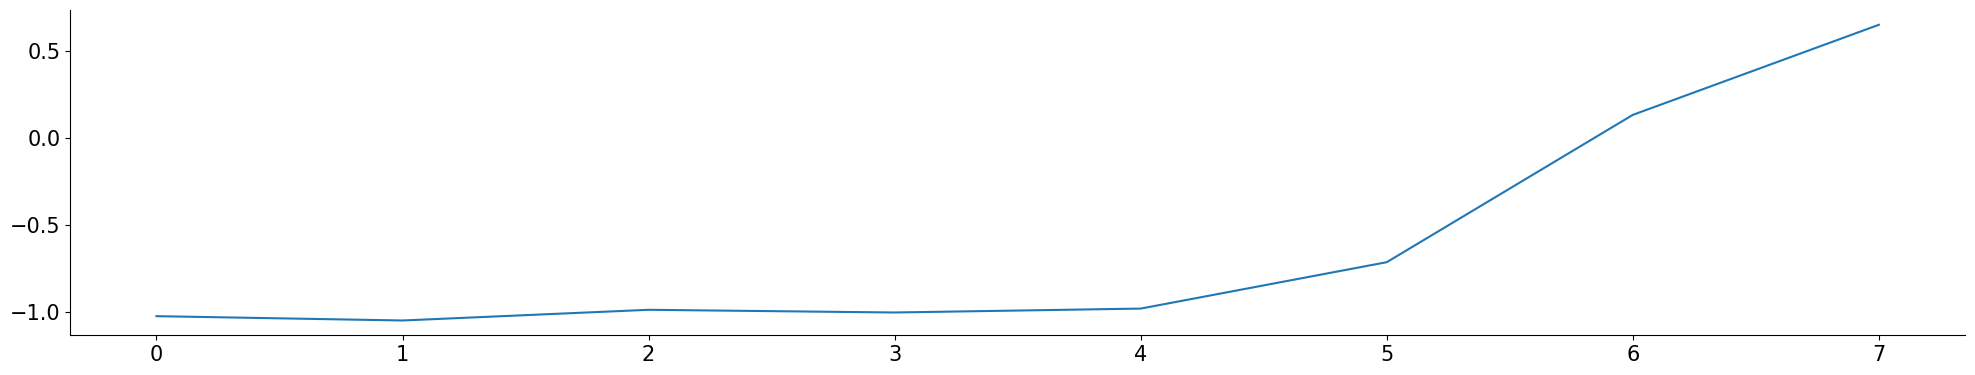

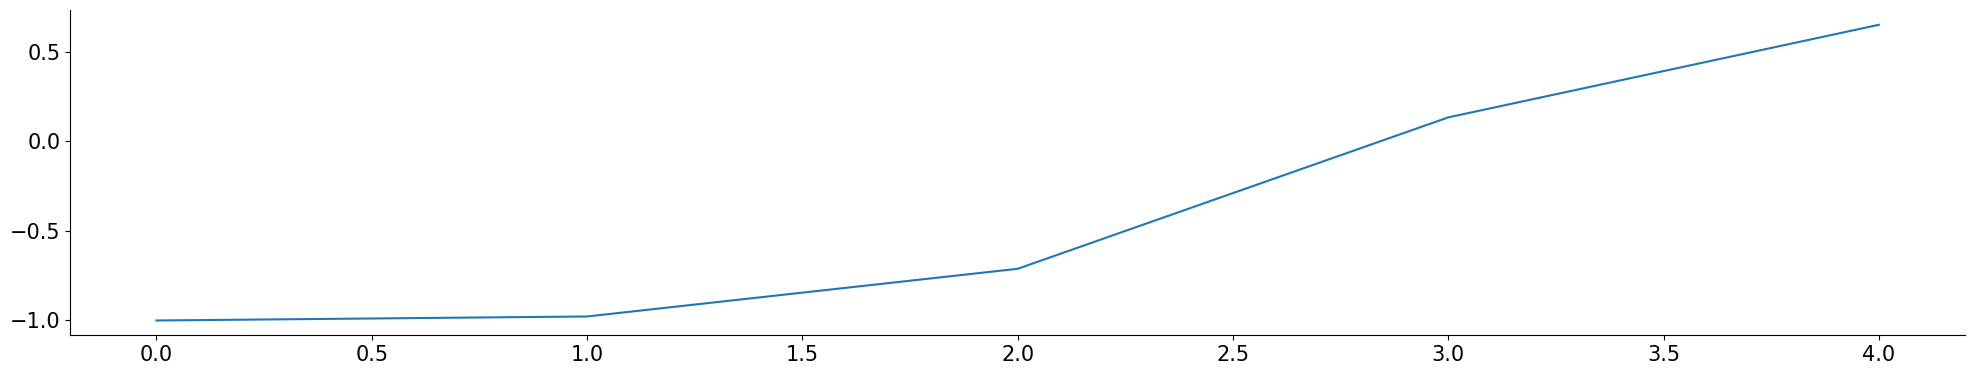

In [228]:
for pair in pairs:
    plt.plot(pupil_z_scores[pair[0]: pair[1]])
    plt.show()

In [225]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll

# Define function to create gradient line
def colorline(x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
    else:
        z = norm(z)
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    return lc

In [220]:
for first_index, second_index in pairs:
    # create a color array for each point
    colors = cmap(np.linspace(0, 1, second_index-first_index))
    
    current_embedding = embedding[first_index:second_index]
    plt.scatter(current_embedding[:, 0], current_embedding[:, 1])

        # plot line for trajectory with color gradient
    for xi, yi, ci in zip(current_embedding[:, 0], current_embedding[:, 1], colors):
        plt.plot(current_embedding[:, 0], current_embedding[:, 1], color=ci)
    # plt.scatter(embedding[first_index:second_index, 0], embedding[first_index:second_index, 1])


TypeError: 'numpy.ndarray' object is not callable

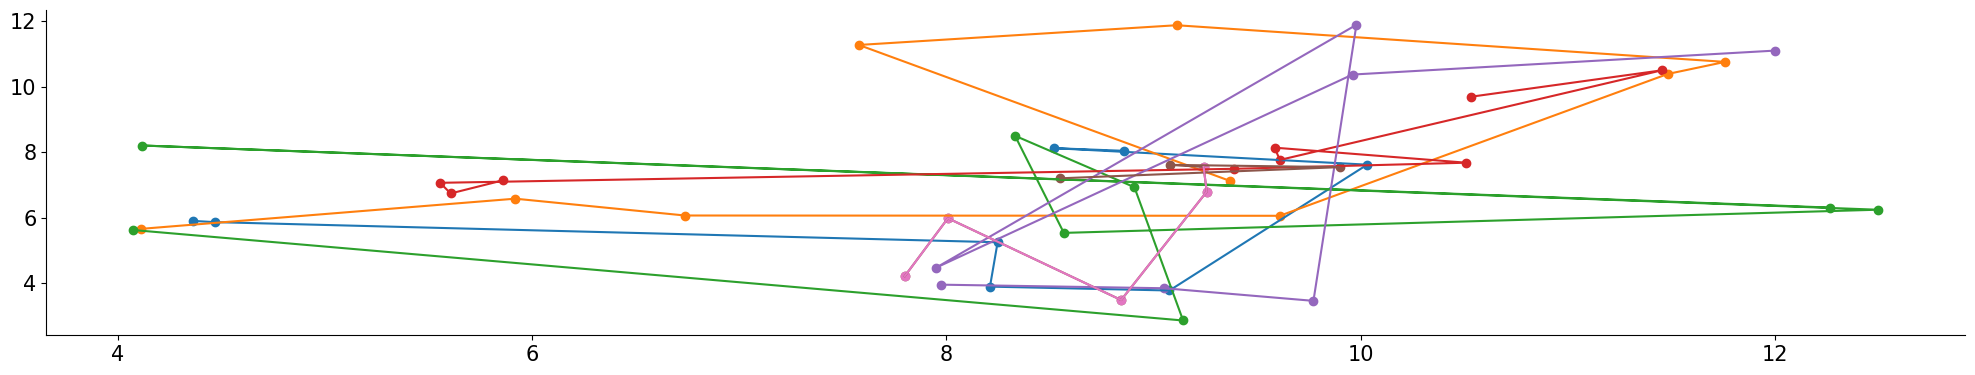

In [227]:
for first_index, second_index in pairs:

    
    current_embedding = embedding[first_index:second_index]
    plt.scatter(current_embedding[:, 0], current_embedding[:, 1])
    plt.plot(current_embedding[:, 0], current_embedding[:, 1])
    # plt.scatter(embedding[first_index:second_index, 0], embedding[first_index:second_index, 1])


In [221]:
# draw trajectories
for trajectory in trajectories:
    x, y = zip(*trajectory)
    plt.plot(x, y)

NameError: name 'trajectories' is not defined

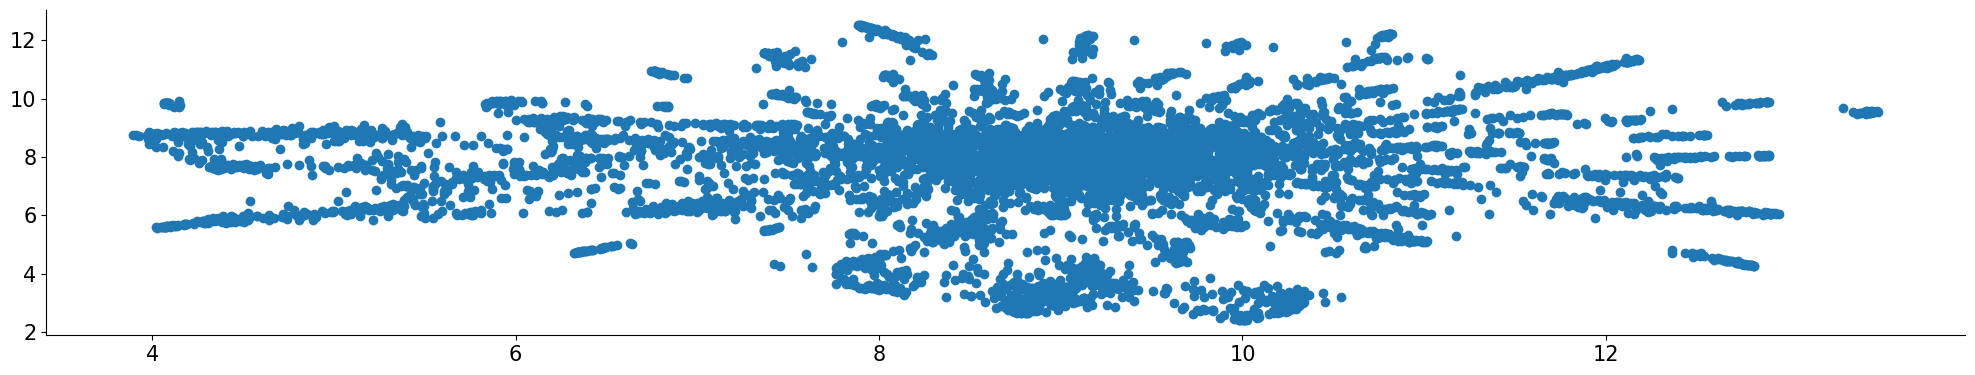

In [215]:
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.show()

In [207]:
big_pupil_indexes

[88,
 112,
 161,
 264,
 343,
 431,
 489,
 492,
 726,
 950,
 1074,
 1077,
 1158,
 1244,
 1356,
 1364,
 1385,
 1419,
 1425,
 1523,
 1562,
 1581,
 1625,
 1632,
 1642,
 1663,
 1678,
 1721,
 1760,
 1766,
 1777,
 1796,
 1803,
 1877,
 1887,
 1924,
 1927,
 1956,
 2000,
 2002,
 2006,
 2100,
 2182,
 2270,
 2782,
 3136,
 3316,
 3400,
 3402,
 3420,
 3728,
 3742,
 3748,
 3807,
 3868,
 3882,
 3889,
 4070,
 4072,
 4155,
 4176,
 4180,
 4253,
 4308,
 4311,
 4393,
 4396,
 4417,
 4452,
 4490,
 4509,
 4597,
 4599,
 4620,
 4648,
 4703,
 4770,
 4873,
 4883,
 4940,
 4942,
 4949,
 5031,
 5057,
 5084,
 5105,
 5148,
 5180,
 5202,
 5229,
 5256,
 5264,
 5287,
 5359,
 5396,
 5402,
 5413,
 5444,
 5476,
 5516,
 5528,
 5608,
 5642,
 5674,
 5741,
 5797,
 5820,
 5873,
 5941,
 5993,
 6000,
 6054,
 6092,
 6137,
 6187,
 6201,
 6228,
 6298,
 6317,
 6323,
 6361,
 6364,
 6394,
 6415,
 6419,
 6428,
 6443,
 6458,
 6465,
 6492,
 6569,
 6585,
 6604,
 6635,
 6672,
 6694,
 6766,
 6805,
 6808,
 6863,
 6865,
 6881,
 6934,
 6958,
 69

(array([ 81., 279., 252., 194., 120.,  53.,  15.,   3.,   1.,   2.]),
 array([-1.90550055, -1.20696553, -0.50843051,  0.19010451,  0.88863953,
         1.58717455,  2.28570957,  2.9842446 ,  3.68277962,  4.38131464,
         5.07984966]),
 <BarContainer object of 10 artists>)

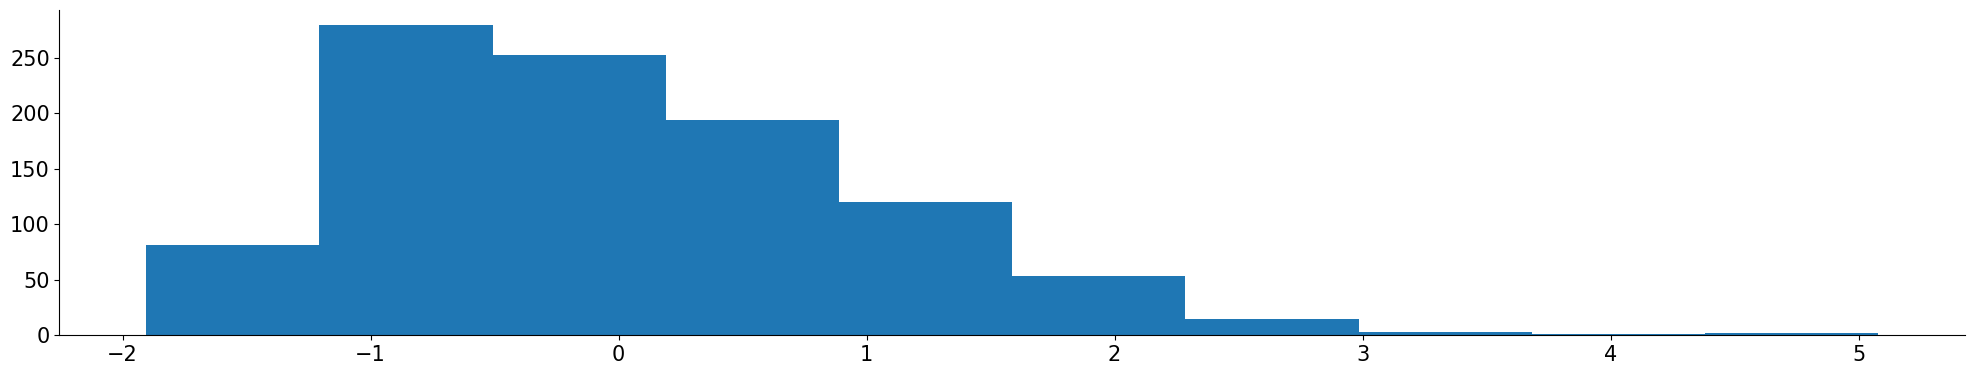

In [165]:
plt.hist(pupil_z_scores)

In [174]:
# Suppose 'time_series' is your 1D numpy array with the time series data
# and 'times' is a 1D numpy array of the same shape as 'time_series', containing the corresponding time points.
# Define your thresholds:
lower_threshold = 0
upper_threshold = 3

# Get the indices where values cross above the lower threshold and below the upper threshold
crossing_above_lower = np.where((pupil_z_scores[:-1] < lower_threshold) & (pupil_z_scores[1:] >= lower_threshold))[0]
crossing_below_upper = np.where((pupil_z_scores[:-1] <= upper_threshold) & (pupil_z_scores[1:] > upper_threshold))[0]

crossing_times = []
for lower in crossing_above_lower:
    # Get the next crossing below the upper threshold
    upper_crossings = crossing_below_upper[crossing_below_upper > lower]
    if upper_crossings.size > 0:  # If there is a crossing below the upper threshold after the current crossing above the lower threshold
        upper = upper_crossings[0]
        crossing_times.append((times[lower], times[upper]))

# Convert the list to a numpy array for further manipulation
crossing_times = np.array(crossing_times)

NameError: name 'times' is not defined

In [167]:
np.where(pupil_z_scores > 2.5)[0]

array([113, 114, 161, 264, 265, 344, 345, 346, 347, 348, 431, 432, 433,
       434], dtype=int64)

In [168]:
high_pupil_area_indexes = np.where(pupil_z_scores > 2.5)[0]

In [169]:
high_pupil_area_indexes

array([113, 114, 161, 264, 265, 344, 345, 346, 347, 348, 431, 432, 433,
       434], dtype=int64)

In [170]:
high_pupil_area_indexes = first_in_consecutive_sequence(high_pupil_area_indexes)

In [171]:
high_pupil_area_indexes

[113, 161, 264, 344, 431]

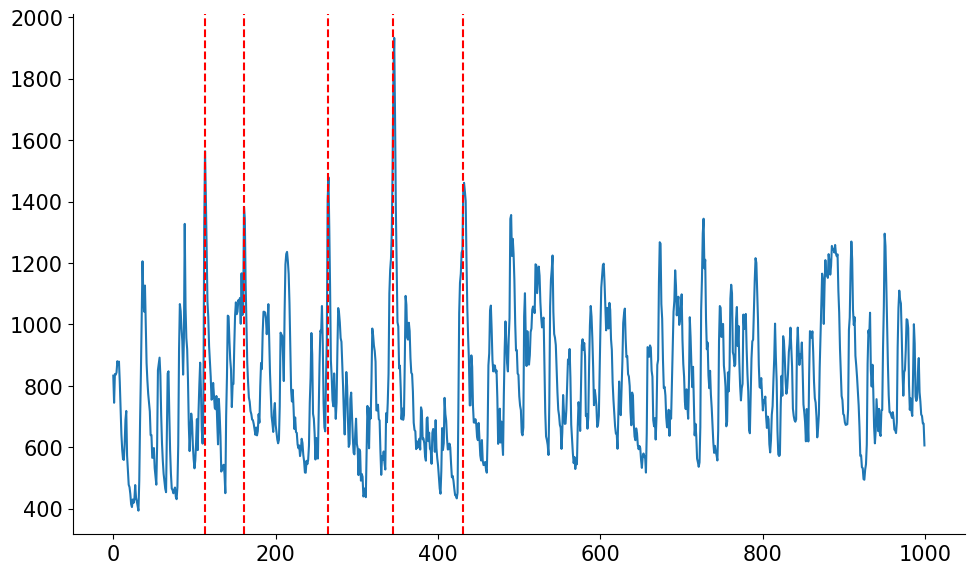

In [172]:
# Plot the data and the detected spikes
plt.figure(figsize=(10, 6))
plt.plot(pupil_area)
for t in high_pupil_area_indexes:
    plt.axvline(x=t, color='r', linestyle='--')
plt.show()

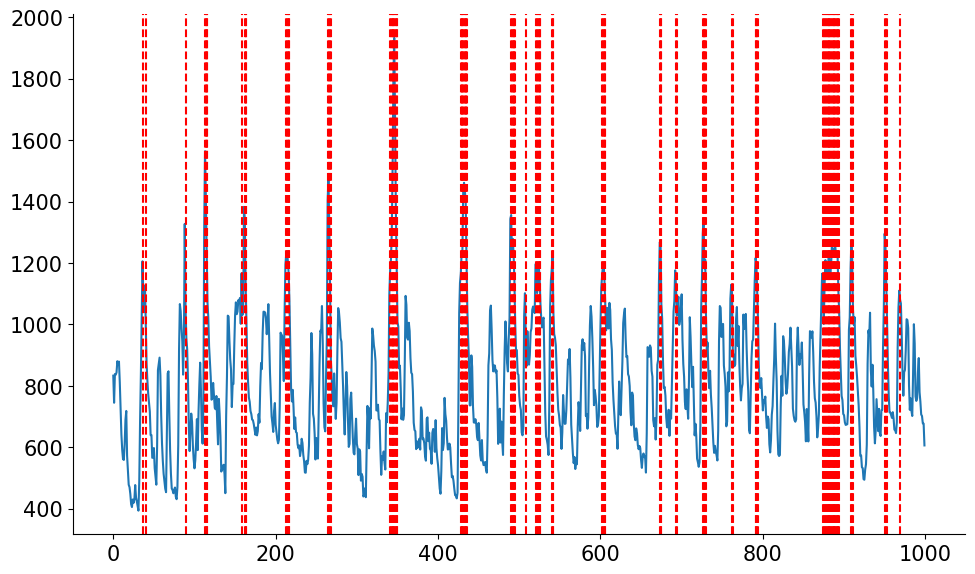

In [173]:
import numpy as np
import matplotlib.pyplot as plt

# Here, "data" is your 1D numpy array with pupil area measurements.
# data = np.array([...])

# Define the threshold value for detecting a sharp increase.
# This should be based on your understanding of what constitutes a "sharp" increase in the specific context of your data.
threshold = 1100

# Compute the difference between consecutive measurements.
diff = np.diff(pupil_area,n=20)

# Find the indices where the difference exceeds the threshold.
# These indices correspond to the end points of the sharp increases.
spike_times = np.where(pupil_area > threshold)[0] + 1  # +1 to point to the end of the increase

# Now, `spike_times` is a 1D numpy array that contains the time points of all sharp increases.

# Plot the data and the detected spikes
plt.figure(figsize=(10, 6))
plt.plot(pupil_area)
for t in spike_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.show()

In [ ]:
import ruptures as rpt


# Define the model ("l1", "rbf", "linear", "normal", "ar"...) and the detection method
model = "l1"  # "l1" model computes the sum of absolute errors, suitable for abrupt changes.
algo = rpt.Pelt(model=model).fit(pupil_area)

# Set the penality value. 
# Higher values will lead to fewer change points.
penalty_value = 1
result = algo.predict(pen=penalty_value)

# Filter the change points to keep only the positive changes
positive_change_points = [result[i] for i in range(1, len(result)-1) if pupil_area[result[i]] - pupil_area[result[i-1]] > 100]

In [ ]:
positive_change_points

In [ ]:
# Display the data and the positive change points
plt.figure(figsize=(10, 6))
plt.plot(pupil_area)
for cp in positive_change_points:
    plt.axvline(x=cp, color='r', linestyle='--')
plt.show()

In [ ]:
# Display the data and the change points
rpt.display(pupil_area, positive_change_points, figsize=(10, 6))
plt.show()

In [ ]:
# Assume pupil_area is a 1D numpy array of your pupil area data
smoothed_pupil_area = np.convolve(pupil_area, np.ones(5)/5, mode='valid')

# Calculate the derivative
derivative = np.diff(smoothed_pupil_area)

# Choose a threshold
threshold = 0.1

# Find the indices where the derivative surpasses the threshold
trial_starts = np.where(derivative > threshold)[0]
trial_ends = np.where(derivative < threshold)[0]

# Make sure we start with a trial start and end with a trial end
if trial_starts[0] > trial_ends[0]:
    trial_ends = trial_ends[1:]
if trial_starts[-1] > trial_ends[-1]:
    trial_starts = trial_starts[:-1]

# Extract the trials
trials = [smoothed_pupil_area[start:end] for start, end in zip(trial_starts, trial_ends)]

In [ ]:
raise ValueError("OLD STUFF)

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

In [ ]:
# @title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupilArea'][:500, 0])
ax.set(xlabel='timepoints', ylabel='pupil area')

ax = plt.subplot(1, 5, 2)
plt.plot(dat['pupilCOM'][:500, :])
ax.set(xlabel='timepoints', ylabel='pupil XY position')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['beh_svd_time'][:500, 0])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['beh_svd_time'][:500, 1])
ax.set(xlabel='timepoints', ylabel='face SVD #1')

ax = plt.subplot(1, 5, 5)
plt.scatter(dat['beh_svd_time'][:, 0], dat['beh_svd_time'][:, 1], s=1)
ax.set(xlabel='face SVD #0', ylabel='face SVD #1')

plt.show()

In [ ]:
# @title take PCA after preparing data by z-score

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components=200).fit_transform(Z)

In [ ]:
# @title Plot PCs. Too many points, switch to logarithmic hexbin!
ax = plt.subplot(1, 5, 1)
plt.scatter(X[:, 0], X[:, 1], s=4, alpha=.1)
ax.set(xlabel='PC 0 ', ylabel='PC 1')

ax = plt.subplot(1, 5, 2)
plt.hexbin(X[:, 0], X[:, 1], gridsize=40, bins='log')
ax.set(xlabel='PC 0 ', ylabel='PC 1', alpha=.1)

plt.show()

In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions.

ncomp = 1 # try 2, then try 3
xinit = 1 * zscore(X[:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=20,
             metric='correlation', transform_seed=42).fit_transform(X)

In [ ]:
embed = embed.flatten()
isort = np.argsort(embed)
RasterMap = uniform_filter1d(Z[isort, :], size=50, axis=0)
RasterMap = zscore(RasterMap[::10, :], axis=1)

In [ ]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
trange = np.arange(1100, 1400)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin=-1, aspect='auto', cmap='gray_r')
ax.set(xlabel='timepoints', ylabel='sorted neurons')
plt.show()

In [ ]:
# now sort with UMAP both the neuron axis and the timepoints axis, bin the sorted matrix and make a sorted Rastermap picture